In [1]:
import skgeom as sg
import matplotlib.pyplot as plt
import numpy as np
import logging
import heapq
from euclid3 import *
from itertools import *
from collections import namedtuple

In [2]:
# _window function takes a list, lst and returns a zipped format of iterables prevs, items and next
def _window(lst):
    prevs, items, nexts = tee(lst, 3) # Return n independent iterators from a single iterable, which is the list lst
    prevs = islice(cycle(prevs), len(lst) - 1, None) # cycle gives an infinite cycle, for example lst = ['A', 'B', 'C'] cycle(lst) will give 'A', 'B', 'C', 'A', 'B', 'C', ...
    #for prevs, islice slices from last element till infinity
    nexts = islice(cycle(nexts), 1, None) #islice starts from index 1 till infinity
    return zip(prevs, items, nexts) # returns zipped list, zip uses the list with shortest length (item) to do the pairing so for every item there exists previous and next

In [3]:
# A demonstration of how the itertools islice and cycle works in _window function
#vert_lst1 = [(100, 50), (200, 200), (250,40), (635,10), (635,250), (500,235), (625,425), (40,520), (40,50)] # Vasan Convention
poly_vert = [(40, 50), (40, 520), (625,425), (500,325), (635,250), (635,10), (250,40), (200,200), (100,50)] # Polyskel Convention

#vert_lst = [[100, 50], [200, 200], [250,40], [635,10], [635,250], [500,235], [625,425], [40,520], [40,50]]
iter_it=_window(poly_vert)
# the iterables can be iterated through just one time
for prev, point, next in iter_it:
    print(prev,point,next)

(100, 50) (40, 50) (40, 520)
(40, 50) (40, 520) (625, 425)
(40, 520) (625, 425) (500, 325)
(625, 425) (500, 325) (635, 250)
(500, 325) (635, 250) (635, 10)
(635, 250) (635, 10) (250, 40)
(635, 10) (250, 40) (200, 200)
(250, 40) (200, 200) (100, 50)
(200, 200) (100, 50) (40, 50)


In [4]:
# Sometimes we might get polygon vertices which lie on the same line or the same point might be repeated again. To avoid that, we normalize the contour. We also convert the vertices to a point instance of Euclid package for geometric manipulation
def _normalize_contour(contour):
    contour = [Point2(float(x), float(y)) for (x, y) in contour]
    return [point for prev, point, next in _window(contour) if not (point == next or (point-prev).normalized() == (next - point).normalized())]

In [5]:
norm_vert = _normalize_contour(poly_vert)

In [6]:
norm_vert

[Point2(40.00, 50.00),
 Point2(40.00, 520.00),
 Point2(625.00, 425.00),
 Point2(500.00, 325.00),
 Point2(635.00, 250.00),
 Point2(635.00, 10.00),
 Point2(250.00, 40.00),
 Point2(200.00, 200.00),
 Point2(100.00, 50.00)]

In [7]:
#defining the cross product (AxB) for vectors A(ax,ay) and B(bx,by) 
def _cross(a, b):
    res = a.x * b.y - b.x * a.y
    return res

In [8]:
# To avoid rounding off errors, we have two functions _approximately_equals(for vectors) and _approximately_same(for points). The function will return both the values are equal if the absolute difference between them are less than 1/1000th of the maximum value
def _approximately_equals(a, b):
    return a == b or (abs(a - b) <= max(abs(a), abs(b)) * 0.001)

def _approximately_same(point_a, point_b):
    return _approximately_equals(point_a.x, point_b.x) and _approximately_equals(point_a.y, point_b.y)

In [9]:
# __slots__ = () is used to avoid the creation of dictionary and faster access to attributes, it is mainly used along with namedtuple ( a built in datatype from collections packages), namedtuple allows us to access the tuple by both keyword and index

# __lt__(self,other), is a method of writing our own less than (lt). ex. I can use it to compare two circles. The default python is for numeric type (5 < 6) or (4.3<4.5)

# __str__(self) is a string representation of this class,  if I use print(object), whatever is written inside __str__ method will be printed

# The following class is for split events, a named tuple _SplitEvent is passed into the class

class _SplitEvent(namedtuple("_SplitEvent", "distance, intersection_point, vertex, opposite_edge")):
    __slots__ = ()

    def __lt__(self, other):
        return self.distance < other.distance

    def __str__(self):
        return "{} Split event @ {} from {} to {}".format(self.distance, self.intersection_point, self.vertex, self.opposite_edge)

# The following class is for Edge events, a named tuple _SplitEvent is passed into the class

class _EdgeEvent(namedtuple("_EdgeEvent", "distance intersection_point vertex_a vertex_b")):
    __slots__ = ()

    def __lt__(self, other):
        return self.distance < other.distance

    def __str__(self):
        return "{} Edge event @ {} between {} and {}".format(self.distance, self.intersection_point, self.vertex_a, self.vertex_b)

In [10]:
# Two other namedtuples, _OriginalEdge for storing Original edges with left and right bisector. The other one is Subtree to store the skeleton arcs as source (intersection point/node), height (distance from the event edge), and sinks (neighbours/connections of the source node).

_OriginalEdge = namedtuple("_OriginalEdge", "edge bisector_left, bisector_right")

Subtree = namedtuple("Subtree", "source, height, sinks")

If I give the vertices in the counter clockwise (CCW) order as (100, 50), (200, 200), ........,(40,520), (40,50). I get the following polygon

<img src="Images/Counter-Clockwise-Convention-Straight-Skeleton.png">


 In polyskel github readme.md documentation, the vertices are given in the following order (40, 50), (40, 520), (625,425), (500,325), (635,250), (635,10), (250,40), (200,200), (100,50), which is in clockwise (CW) order. In code comments, it is clearly mentioned the order is counterclockwise. In addition, the original image in polyskel implementation isshown as below:

<img src="Images/Original-image-in-polyskel.png">


If you look at them closely, the polyskel documentation image is mirrored in the y-axis. i.e. the positive x axis runs from left of the screen to the right of the screen and the positive y-axis runs from top of the screen to the bottom of the screen. If you assume this convention, then you get the following image which is similar to polyskel documentation. The order of vertices is also in counterclockwise (CCW) direction. 

<img src="Images/X-Y-Convention1.png">




This convention is also confirmed by the fact that the cross product signs are reversed. If you take polyskel convention, the cross product vector of X with Y axis is perpendicular to the plane of paper/screen and the postitive direction for 'z' is into the screen (pointing away from you). In normal convention, the cross product vector of X with Y axis is perpendicular to the plane of paper/screen but the positive direction for 'z' is away from the screen (pointing towards you).


First, let me run the code with polyskel convention to make sure we understand the code. Then we can run it according to normal convention



In [11]:
# One of the most important classes of this program is _LAVertex, I will try to explain this class as detailed as possible

class _LAVertex:
    # you pass the point (vertex), left edge for the vertex, right edge. if possible, direction vectors also. You initiate the vertex validity, self._valid = True
    def __init__(self, point, edge_left, edge_right, direction_vectors=None):
        self.point = point
        self.edge_left = edge_left
        self.edge_right = edge_right
        self.prev = None
        self.next = None
        self.lav = None
        self._valid = True
        
        
        # TODO this might be handled better. Maybe membership in lav implies validity?   
        #The order of vertices of the polygon must be given in counter clockwise direction, so an edge pointing towards or entering the vertex is the left edge and an edge             pointing away from or leaving the vertex is called the right edge

        #Edge left direction is reversed (multiplied by -1) so that the direction is pointing away from or leaving the vertex, by doing this we can see that both edge left             and edge right start from the vertex, these vectors are called as creator vectors

        #If there are no direction vectors, creator vectors formed from edge left and edge right vectors will be assigned to direction vectors
        #creator_vectors = (edge_left.v.normalized() * -1, edge_right.v.normalized())
        creator_vectors = (edge_left.v.normalized()*-1, edge_right.v.normalized())
        if direction_vectors is None:
            direction_vectors = creator_vectors


        #To find whether a vertex is reflex or not, we take the cross product of vectors at the vertex (direction vectors). For reflex vertex, the angle between reversed left edge and right edge is less than 180 which makes the cross product resultant vector magnitude positive but the resultant vector direction is perpendicular to screen and points towards you, which according to polyskel convention is negative, so if the cross product of creation/direction vectors is negative, then the vertex is reflex

        self._is_reflex = ((_cross(*direction_vectors)) < 0) # original polyskel code convention
        #self._is_reflex = ((_cross(*direction_vectors)) > 0) # Vasan/normal code convention

        #Angular bisector and description of vector geometry is given in the markdown cell below this cell
        self._bisector = Ray2(self.point, operator.add(*creator_vectors) * (-1 if self.is_reflex else 1))
        #log.info("Created vertex %s", self.__repr__())
        #_debug.line((self.bisector.p.x, self.bisector.p.y, self.bisector.p.x + self.bisector.v.x * 100, self.bisector.p.y + self.bisector.v.y * 100), fill="blue")

    #@property decorator helps us to change the attributes (bisector,_is_reflex,.lav._slav._original_edges) and ensures that the change is reflected on other attributes which depend on this attribute. Without property decorator, you can achieve that by making these attributes as part of methods. If you do that, you have to call them as bisector() not self.bisector. If you forget () sometimes, it might break the code. @property decorator is a convenient way. For further explanation, please have a look at this link - https://www.machinelearningplus.com/python/python-property/


    @property
    def bisector(self):
        return self._bisector

    @property
    def is_reflex(self):
        return self._is_reflex

    @property
    def original_edges(self):
        # pylint: disable=maybe-no-member
        return self.lav._slav._original_edges

# next_event is an important method which calculates the events for a given a vertex

    def next_event(self):
        events = []
        if self.is_reflex:
            # a reflex vertex may generate a split event
            # split events happen when a vertex hits an opposite edge, splitting the polygon in two.
            #log.debug("looking for split candidates for vertex %s", self)
            for edge in self.original_edges: #self.original_edges calls the function original edges inside this _LAVertex class which returns _slav._original_edges
                if edge.edge == self.edge_left or edge.edge == self.edge_right:
                    continue

                #log.debug("\tconsidering EDGE %s", edge) #uncomment in polyskel code

                # a potential b is at the intersection of between our own bisector and the bisector of the
                # angle between the tested edge and any one of our own edges.

                # we choose the "less parallel" edge (in order to exclude a potentially parallel edge) #explanation in cells below
                leftdot = abs(self.edge_left.v.normalized().dot(edge.edge.v.normalized()))
                rightdot = abs(self.edge_right.v.normalized().dot(edge.edge.v.normalized()))
                selfedge = self.edge_left if leftdot < rightdot else self.edge_right # if left edge is less parallel, choose it as self edge and right edge as other
                otheredge = self.edge_left if leftdot > rightdot else self.edge_right # if right edge is less parallel, choose it as other edge and right edge as self edge

                i = Line2(selfedge).intersect(Line2(edge.edge)) #intersection point, i between less parallel edge (self edge) and edge to the checked(edge.edge) 
                if i is not None and not _approximately_equals(i, self.point): #check that intersection exists(not None) and not equal to the reflex vertex point(self.point)
                    # locate candidate b
                    linvec = (self.point - i).normalized() #(vertex point - intersection point) normalized
                    edvec = edge.edge.v.normalized() # normalized edge vector
                    if linvec.dot(edvec) < 0: #proper intersection happens only if linvec.dot(edvec) > 0, else, the direciton of edvec is reversed (look at cell below)
                        edvec = -edvec

                    bisecvec = edvec + linvec # bisector vector of edvec and linvec
                    if abs(bisecvec) == 0: # To make sure that linvec and edvec are not parallel
                        continue
                    bisector = Line2(i, bisecvec) #Line2 in euclid extends infintely on both sides, bisector passes through i (intersection) and has a direction of bisecvec
                    b = bisector.intersect(self.bisector) #find the intersection of reflex vector bisector (self.bisector) with bisecvec  

                    if b is None: #if there is no intersection, then move on to the next vertex
                        continue

                    # If there is an intersection, we need to check the eligibility of b
                    # a valid intersection b should lie within the area limited by the edge and the bisectors of its two vertices (look at the note in below cells):
                    xleft   = _cross(edge.bisector_left.v.normalized(), (b - edge.bisector_left.p).normalized()) > 0 #sign is reversed because of polyskel convention
                    xright  = _cross(edge.bisector_right.v.normalized(), (b - edge.bisector_right.p).normalized()) < 0 #sign is reversed - polyskel convention
                    xedge   = _cross(edge.edge.v.normalized(), (b - edge.edge.p).normalized()) < 0 #sign is reversed - polyskel convention

                    if not (xleft and xright and xedge): #if any of the conditions are not satisfied, then it is invalid, so move on to the next vertex
                        #log.debug("\t\tDiscarded candidate %s (%s-%s-%s)", b, xleft, xright, xedge)
                        continue

                    #log.debug("\t\tFound valid candidate %s", b)
                    events.append(_SplitEvent(Line2(edge.edge).distance(b), b, self, edge.edge)) #append it to the events using _SplitEvent named tuple

        i_prev = self.bisector.intersect(self.prev.bisector) #intersection of current convex vertex bisector with previous vertex bisector
        i_next = self.bisector.intersect(self.next.bisector) #intersection of current convex vertex bisector with next vertex bisector

        if i_prev is not None: #i_prev exists only for convex vertex
            events.append(_EdgeEvent(Line2(self.edge_left).distance(i_prev), i_prev, self.prev, self)) #append the event to events with _EdgeEvent tuple (three items) with distance between i_prev (intersection point) and edge_left line, i_prev (intersection point) and previous vertex 
        if i_next is not None: #i_next exists only for convex vertex
            events.append(_EdgeEvent(Line2(self.edge_right).distance(i_next), i_next, self, self.next)) #append the event to events with _EdgeEvent tuple (three items) with distance between i_next (intersection point) and edge_right line, i_next (intersection point) and next vertex 

        if not events: #If there are no events, return None
            return None

        ev = min(events, key=lambda event: self.point.distance(event.intersection_point)) #Find the minimum of the events by distance. The procedure for convex events is given in the cell after bisectors handwritten note

        #log.info("Generated new event for %s: %s", self, ev)
        return ev

#method to invalidate the vertex, so it is not considered the next time
    def invalidate(self):
        if self.lav is not None:
            #pylint: disable=too-many-function-args
            self.lav.invalidate(self)
        else:
            self._valid = False

    @property
    def is_valid(self):
        return self._valid

    def __str__(self):
        return "Vertex ({:.2f};{:.2f})".format(self.point.x, self.point.y)

    def __repr__(self):
        return "Vertex ({}) ({:.2f};{:.2f}), bisector {}, edges {} {}".format("reflex" if self.is_reflex else "convex",
                                                                              self.point.x, self.point.y, self.bisector,
                                                                              self.edge_left, self.edge_right)

### Explanations for some vector algebra concepts used in polyskel

<img src="Images/page1.png">

<img src="Images/page2.png">

<img src="Images/page3.png">

<img src="Images/page4.png">



### Convex Event Explanation

<img src="Convex-Event.png">

### Dot Product of Vectors for Less Parallel Edges

<img src="Images/Dot-product1.png">

<img src="Images/Dot-product2.png">


### Valid Events - Split

<img src="Images/ValidEvent1.png">

<img src="Images/ValidEvent2.png">

<img src="Images/ValidEvent3.png">

<img src="Images/ValidEvent4.png">

In [12]:
# The first class in skeletonize function
class _SLAV:
    def __init__(self, polygon, holes):
        contours = [_normalize_contour(polygon)] #_normalize_contour function explained in previous cells for a polygon
        contours.extend([_normalize_contour(hole) for hole in holes]) #Do the _normalize contour function for the number of holes in polygon, add them to the contours list

        self._lavs = [_LAV.from_polygon(contour, self) for contour in contours] # Now call the from_polygon() method _LAV class (one cell below this cell)

        # store original polygon edges for calculating split events, the _OriginalEdge Tuple stores three items for every vertex - 1.The linesegment from previous vertex to the current vertex 2. Bisector of previous vertex 3. Bisector of current vertex. chain.from_iterable(lists) is a method of itertools module. It combines the various lists to make a single list, so you can iterate through each element of the lists. Here we iterate through every vertex in the self._lavs 
        self._original_edges = [
            _OriginalEdge(LineSegment2(vertex.prev.point, vertex.point), vertex.prev.bisector, vertex.bisector)
            for vertex in chain.from_iterable(self._lavs)
        ]
# An iterator method which iterates through the list of active vertices (LAV)
    def __iter__(self):
        for lav in self._lavs:
            yield lav
# A method for finding the length of _lavs
    def __len__(self):
        return len(self._lavs)
# Check whether the _lavs is empty or not
    def empty(self):
        return len(self._lavs) == 0
# Handling of edge events
    def handle_edge_event(self, event):
        sinks = [] #initialize an empty list called sinks
        events = [] #initialize an emptly list called events

        lav = event.vertex_a.lav #assign the lav of vertex_a of the event to lav
        if event.vertex_a.prev == event.vertex_b.next: #if prev of vertex_a is equal to next of vertex_b then it is a peak event
            #log.info("%.2f Peak event at intersection %s from <%s,%s,%s> in %s", event.distance, event.intersection_point, event.vertex_a, event.vertex_b, event.vertex_a.prev, lav)
            self._lavs.remove(lav) #remove the lav
            for vertex in list(lav): #for every vertex in the list of lav
                sinks.append(vertex.point) # append the vertex point to sink
                vertex.invalidate() #invalidate the vertex
        else:
            #log.info("%.2f Edge event at intersection %s from <%s,%s> in %s", event.distance, event.intersection_point, event.vertex_a, event.vertex_b, lav)
            new_vertex = lav.unify(event.vertex_a, event.vertex_b, event.intersection_point) #pass vertex_a, vertex_b, intersection_point of event to unify method of LAV class. The unify method returns the replacement vertex which is an instance of _LAVertex with intersection point
            if lav.head in (event.vertex_a, event.vertex_b): #check if lav.head is in event.vertex_a or event.vertex_b
                lav.head = new_vertex #in that case, the new_vertex (replacement vertex) becomes the head
            sinks.extend((event.vertex_a.point, event.vertex_b.point)) #vertex_a.point and vertex_b.point are added to the sinks
            next_event = new_vertex.next_event() #now calculate next_event for this new_vertex(replacement vertex)
            if next_event is not None: #if there is a next_event for new_vertex (replacement vertex)
                events.append(next_event) #append it to the events, which was initially an empty list

        return (Subtree(event.intersection_point, event.distance, sinks), events) #return both - a namedtuple Subtree and events

    def handle_split_event(self, event):
        lav = event.vertex.lav
        #log.info("%.2f Split event at intersection %s from vertex %s, for edge %s in %s", event.distance,
                 #event.intersection_point, event.vertex, event.opposite_edge, lav)

        sinks = [event.vertex.point] #for split event, the only sink will be the reflex vertex
        vertices = []
        x = None  # right vertex
        y = None  # left vertex
        norm = event.opposite_edge.v.normalized() #normalized opposite edge of event
        for v in chain.from_iterable(self._lavs): #Take all the vertices of polygon
            #log.debug("%s in %s", v, v.lav)
            #check whether the vertex v's normalized left edge vector is equal to norm and the point of event opposite edge (P) is equal to vertex v's left edge point
            #else if whether the vertex v's normalized right edge vector is equal to norm and the point of event opposite edge (P) is equal to vertex v's right edge point
            if norm == v.edge_left.v.normalized() and event.opposite_edge.p == v.edge_left.p:
                x = v #if true assign the vertex v to x(right vertex)(initially none)
                y = x.prev #the previous of x is pointed to y (left vertex) (initially none)
            elif norm == v.edge_right.v.normalized() and event.opposite_edge.p == v.edge_right.p:
                y = v #elif true assign the vertex v to y(left vertex)
                x = y.next #the next of y is pointed to x(right vertex)

            if x: #if x is not none, check the direction of cross product vectors
                xleft   = _cross(y.bisector.v.normalized(), (event.intersection_point - y.point).normalized()) >= 0
                xright  = _cross(x.bisector.v.normalized(), (event.intersection_point - x.point).normalized()) <= 0
                #log.debug("Vertex %s holds edge as %s edge (%s, %s)", v, ("left" if x == v else "right"), xleft, xright)

                if xleft and xright: # if both are true exit the iteration loop
                    break
                else: # else assign x and y as None 
                    x = None
                    y = None

        if x is None: #if x is None
            #log.info("Failed split event %s (equivalent edge event is expected to follow)", event)
            return (None, []) #A failed split event and exits the function

        v1 = _LAVertex(event.intersection_point, event.vertex.edge_left, event.opposite_edge) #instance of _LAVertex with event's intersection, edge left and opposite edge. It means that in v1 instance for the intersection point, edge left acts as left edge and opposite edge acts as right edge
        v2 = _LAVertex(event.intersection_point, event.opposite_edge, event.vertex.edge_right) #instance of _LAVertex with event's intersection, opposite edge and edge right. It means that in v2 instance for the intersection point, opposite edge acts as left edge and edge right acts as right edge

#Have a look at the handwritten notes to get a better idea
        v1.prev = event.vertex.prev # for v1, the previous vertex of event vertex is also the previous vertex of v1
        v1.next = x #the next vertex of v1 is the right vertex x
        event.vertex.prev.next = v1 # the next vertex of event.vertex.prev is the v1 vertex itelf
        x.prev = v1 # v1 vertex is the previous vertex of right vertex x

        v2.prev = y # the previous vertex of v2 is the left vertex y
        v2.next = event.vertex.next #the next vertex of v2 is the next vertex of event vertex
        event.vertex.next.prev = v2 # event.vertex.next's previous vertex is v2
        y.next = v2 # the next vertex of y is the vertex v2

        new_lavs = None # Initially there are no new_lavs
        self._lavs.remove(lav) #remove the current lav
        if lav != x.lav: #if event vertex lav is not equal to x.lav (which means both are not same points)
            # the split event actually merges two lavs
            self._lavs.remove(x.lav) #remove the x.lav
            new_lavs = [_LAV.from_chain(v1, self)] #class method from_chain in _LAV class is called without instantiation, which is the advantage of class method
        else:
            new_lavs = [_LAV.from_chain(v1, self), _LAV.from_chain(v2, self)] #create two new _LAVs from vertex v1 and v2

        for l in new_lavs:
            #log.debug(l)
            if len(l) > 2:
                self._lavs.append(l) #append the new lavs to the original ones
                vertices.append(l.head) #append the head vertex of each lav
            else: # if length of new_lavs is less than 2
                #log.info("LAV %s has collapsed into the line %s--%s", l, l.head.point, l.head.next.point)
                sinks.append(l.head.next.point)  # append the next vertex point of head of lav
                for v in list(l): #invalidate the vertex is list l (if you have less than two lavs)
                    v.invalidate()

        events = [] # initialize a null list events
        for vertex in vertices: #for vertex in the head 
            next_event = vertex.next_event() #find next event
            if next_event is not None:
                events.append(next_event) #append the next event to events list

        event.vertex.invalidate() #invalidate the event vertex
        return (Subtree(event.intersection_point, event.distance, sinks), events) #return the subtree

### Handling of edge and split events today

<img src="Images/Handling1.png">

<img src="Images/Handling2.png">

<img src="Images/Handling3.png">

<img src="Images/Handling4.png">

<img src="Images/Handling5.png">

<img src="Images/Handling6.png">

<img src="Images/Handling7.png">

<img src="Handling8.png">

<img src="Handling9.png">

<img src="Handling10.png">



In [13]:
class _LAV:
    def __init__(self, slav):
        self.head = None
        self._slav = slav
        self._len = 0 #assign initial length to zero
        #log.debug("Created LAV %s", self)

#Explanation of classmethod can be found in https://realpython.com/instance-class-and-static-methods-demystified/
# The advantage of using @classmethod is that I can accesss the functions of the class directly without creating an object (instance) of the class, for ex. I can directly call _LAV.from_polygon(). If I use normal method, then I have to create an instance like poly = _LAV() and then use poly.from_polygon(), if I call directly _LAV.from_polygon() without class method, it will throw an error. Another difference is the use of cls instead of self in classmethod
    @classmethod
    def from_polygon(cls, polygon, slav):
        lav = cls(slav) #assign the given circular list of active vertices as lav
        for prev, point, next in _window(polygon): #_window function returns prev, point and next iterator
            lav._len += 1 #increase the length of lav by 1 (initially set to 0)
            vertex = _LAVertex(point, LineSegment2(prev, point), LineSegment2(point, next)) # vertex object is an instance of _LAVertex class, the arguments passed are point, edge_left (linesegment(prev,point)) and edge_right (linesegment(point,next))
            vertex.lav = lav # vertex.lav is an instantiation of lav. For the first iteration of the loop, lav is none. For subsequent iterations, vertices are added
            if lav.head is None: #initially, lav.head is None
                lav.head = vertex #assign the first vertex as the head of lav
                vertex.prev = vertex.next = vertex #assign vertex as its previous and next item
            else:
                vertex.next = lav.head #From second vertex, lav.head is the first vertex. It is assigned to vertex.next. For every iteration(vertex), vertex.next and vertex.prev are initially none
                vertex.prev = lav.head.prev #Similarly, lav.head.prev, which is firstVertex.prev = firstvertex. The assignment happened inside lav.head = None, where we used vertex.prev = vertex.next = vertex, so first vertex is assigned to second vertex.prev, which is logical as the previous of second vertex is the first vertex.
                vertex.prev.next = vertex # vertex.prev is first vertex and now the next of first vertex is second vertex, which implies vertex.prev.next = vertex
                lav.head.prev = vertex # Assuming a circular relationship where only two vertices are present and second vertex is the last vertex, which implies the previous of first vertex is the second vertex. lav.head is the first vertex and previous of that vertex is second vertex. The logic continues for 3rd, 4th, till nth vertex of the polygon. I have attached a handwritten note to understand these assignments.
        return lav #Finally once you iterate through the polygon verties

    @classmethod
    def from_chain(cls, head, slav): #used to create new lavs 
        lav = cls(slav)
        lav.head = head
        for vertex in lav:
            lav._len += 1
            vertex.lav = lav
        return lav

    def invalidate(self, vertex):
        assert vertex.lav is self, "Tried to invalidate a vertex that's not mine"
        #log.debug("Invalidating %s", vertex)
        vertex._valid = False
        if self.head == vertex:
            self.head = self.head.next
        vertex.lav = None

    def unify(self, vertex_a, vertex_b, point):
        replacement = _LAVertex(point, vertex_a.edge_left, vertex_b.edge_right,
                                (vertex_b.bisector.v.normalized(), vertex_a.bisector.v.normalized()))
        replacement.lav = self

        if self.head in [vertex_a, vertex_b]:
            self.head = replacement

        # look at the handwritten note to make sense of replacement vertex assignments. vertex_a and vertex_b causing the edge event will be invalidated, so we have to assign proper circularity (next, previous etc)
        vertex_a.prev.next = replacement #The previous vertex of Va should now point its next arrow to replacement vertex
        vertex_b.next.prev = replacement #The next vertex of Vb should now point its previous arrow to replacement vertex
        replacement.prev = vertex_a.prev #Similarly, the previous of replacement vertex should point to previous of vertex a
        replacement.next = vertex_b.next #The next of replacement vertex should point to next of vertex b

        vertex_a.invalidate()
        vertex_b.invalidate()

        self._len -= 1 #reduce the length of lav by 1
        return replacement #which is a _LAVertex instance

    def __str__(self):
        return "LAV {}".format(id(self))

    def __repr__(self):
        return "{} = {}".format(str(self), [vertex for vertex in self])

    def __len__(self):
        return self._len

    def __iter__(self):
        cur = self.head
        while True:
            yield cur
            cur = cur.next
            if cur == self.head:
                return

    def _show(self):
        cur = self.head
        while True:
            print(cur.__repr__())
            cur = cur.next
            if cur == self.head:
                break

Here are the handwritten notes for the iteration


<img src="LAV11.png">

<img src="LAV2.png">

<img src="LAV3.png">




In [14]:
class _EventQueue:
    def __init__(self):
        self.__data = []

    def put(self, item):
        if item is not None:
            heapq.heappush(self.__data, item) #use heapq, python implementation of heap queue to push the element to the event

    def put_all(self, iterable):
        for item in iterable:
            heapq.heappush(self.__data, item) #heapq push for iterables

    def get(self):
        return heapq.heappop(self.__data) #heapq pop to get the item from queue

    def empty(self):
        return len(self.__data) == 0 #boolean to check whether the heapq is empty or not

    def peek(self):
        return self.__data[0] #get the first item of the eventqueue

    def show(self):
        for item in self.__data: #show the items of the queue
            print(item)

In [15]:
def _merge_sources(skeleton):
    """
    In highly symmetrical shapes with reflex vertices multiple sources may share the same 
    location. This function merges those sources.
    """
    sources = {}
    to_remove = []
    for i, p in enumerate(skeleton):
        source = tuple(i for i in p.source)
        if source in sources:
            source_index = sources[source]
            # source exists, merge sinks
            for sink in p.sinks:
                if sink not in skeleton[source_index].sinks:
                    skeleton[source_index].sinks.append(sink)
            to_remove.append(i)
        else:
            sources[source] = i
    for i in reversed(to_remove):
        skeleton.pop(i)

Now, let us start with the skeletonize function in polyskel program and go through the program step by step

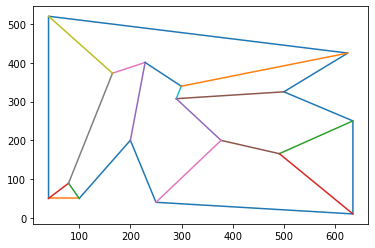

In [16]:
def skeletonize(polygon, holes=None):
    """
    Compute the straight skeleton of a polygon.

    The polygon should be given as a list of vertices in counter-clockwise order.
    Holes is a list of the contours of the holes, the vertices of which should be in clockwise order.

    Returns the straight skeleton as a list of "subtrees", which are in the form of (source, height, sinks),
    where source is the highest points, height is its height, and sinks are the point connected to the source.
    """
    slav = _SLAV(polygon, holes) #instantiation of _SLAV class
    output = []
    prioque = _EventQueue() #instantiation of _EventQueue class

    for lav in slav: #for list of active vertices(lav) in SLAV
        for vertex in lav:
            prioque.put(vertex.next_event()) #for every vertex in lav, call next_event to calculate the event(edge/split)

    while not (prioque.empty() or slav.empty()): #as long as the prioque or slav is not empty, enter the loop
        #log.debug("SLAV is %s", [repr(lav) for lav in slav])
        i = prioque.get() #get method of prioque class, which is pop the event from heap queue
        if isinstance(i, _EdgeEvent): # The isinstance() function checks if the object (first argument) is an instance or subclass of classinfo class (second argument). classinfo: class, type, or tuple of classes and types
            if not i.vertex_a.is_valid or not i.vertex_b.is_valid: #if one of the vertex is invalid, go and get next event
                #log.info("%.2f Discarded outdated edge event %s", i.distance, i)
                continue

            (arc, events) = slav.handle_edge_event(i) # if it is a valid vertex, pass the edge event to handle_edge_event method of slav instance of _SLAV class. It returns a namedtuple called subtree (stored as arc now) and events (stored as events)
        elif isinstance(i, _SplitEvent):
            if not i.vertex.is_valid:
                #log.info("%.2f Discarded outdated split event %s", i.distance, i)
                continue
            (arc, events) = slav.handle_split_event(i) # if it is a valid vertex, pass the edge event to handle_split_event method of slav instance of _SLAV class. It returns a namedtuple called subtree (stored as arc now) and events (stored as events)

        prioque.put_all(events) #put all the events in priority queue

        if arc is not None:
            output.append(arc)
            #for sink in arc.sinks:
                #_debug.line((arc.source.x, arc.source.y, sink.x, sink.y), fill="red")

            #_debug.show()
    _merge_sources(output)
    return output
#poly_vert = [(5,0), (6,4), (4,5), (1,5), (1,0)]
#poly_vert = [(0,0), (5,0), (9,3), (5,6), (0,5)]
#poly_vert = [(4,0), (8,7), (5,10), (1,10), (-2,3)]
poly_vert = [(40, 50), (40, 520), (625,425), (500,325), (635,250), (635,10), (250,40), (200,200), (100,50)]
#poly_vert = [(100, 50), (200, 200), (250,40), (635,10), (635,250), (500,235), (625,425), (40,520), (40,50)]
skelton_out = skeletonize(poly_vert,[]) # uncomment later
p_x, p_y = zip(*poly_vert)
plt.plot(p_x,p_y)
plt.plot((p_x[-1],p_x[0]), (p_y[-1],p_y[0]))

#uncomment the following lines later
for subt in skelton_out:    
    for n in subt.sinks:        
        plt.plot((subt.source.x, n.x), (subt.source.y,n.y))

plt.show()
